# データの準備

In [1]:
import pandas as pd
import numpy as np
np.random.seed(529)

# データの読み込み
email_data = pd.read_csv('http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

# 女性向けメール配信データの削除と介入変数の追加
male_df = email_data.copy()  # SettingWithCoppyWarningを回避するためにコピーしているが、本質的に意味はない
male_df = male_df[male_df['segment'] != 'Womens E-Mail']
male_df['treatment'] = male_df['segment'].apply(lambda x: 1 if x == 'Mens E-Mail' else 0)

# バイアスのあるデータの準備
obs_rate_c = 0.5
obs_rate_t = 0.5

biased_data = male_df.copy()
biase_rule = (biased_data['history'] > 300) | (biased_data['recency'] < 6) | (biased_data['channel'] == 'Multichannel')
biased_data['obs_rate_c'] = biase_rule.apply(lambda x: obs_rate_c if x else 1)
biased_data['obs_rate_t'] = biase_rule.apply(lambda x: 1 if x else obs_rate_t)
biased_data['random_number'] = np.random.uniform(size=biased_data.shape[0])
biased_data = (
    biased_data[
                ((biased_data['treatment'] == 0) & (biased_data['random_number'] < biased_data['obs_rate_c']))
                | ((biased_data['treatment'] == 1) & (biased_data['random_number'] < biased_data['obs_rate_t']))
                ]
)

# ロジスティック回帰

## sklearn

In [2]:
from sklearn.linear_model import LogisticRegression

X = pd.get_dummies(biased_data[['recency', 'history', 'channel']])  # channelをダミー変数化
treatment = biased_data['treatment'] 

model = LogisticRegression().fit(X, treatment)

In [3]:
model.intercept_, model.coef_

(array([0.59362486]),
 array([[-0.12416563,  0.00059096,  0.38100911,  0.10874707,  0.10332302]]))

## statsmodels

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import glm, logit

# モデルの学習
model = glm('treatment ~ history + recency + channel', data=biased_data, family=sm.families.Binomial()).fit()  # MultiChannelが反映されない
# model = logit('treatment ~ history + recency + channel', data=biased_data).fit()  # 上と同様
# sklearnの結果と一致しない

biased_data2 = pd.get_dummies(biased_data[['treatment', 'recency', 'history', 'channel']])  # channelをダミー変数化すると、sklearnと一致する
model = glm('treatment ~ history + recency + channel_Multichannel + channel_Phone + channel_Web', data=biased_data2, family=sm.families.Binomial()).fit()

In [6]:
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              treatment   No. Observations:                32050
Model:                            GLM   Df Residuals:                    32045
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21122.
Date:                Sat, 27 Jun 2020   Deviance:                       42245.
Time:                        14:27:08   Pearson chi2:                 3.22e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.5939      0.023     25.509      0.000       0.548       0.640
history                  0.0006   5.42e-05     10.894      0.000       0.000       0.001
recency                 -0.1242      0.003    -36.249      0.000      -0.131      -0.117
channel_Multichannel     0.3824      0.031     12.354      0.000       0.322       0.443
channel_Phone            0.1026      0.017      5.974      0.000       0.069       0.136
channel_Web              0.1089      0.017      6.359      0.000       0.075       0.143
========================================================================================
"""

In [7]:
biased_data.groupby(['treatment', 'channel']).size()

treatment  channel     
0          Multichannel    1346
           Phone           6715
           Web             6769
1          Multichannel    2577
           Phone           7271
           Web             7372
dtype: int64

# 傾向スコアを用いた効果推定

In [8]:
!pip install -q dowhy

In [9]:
import dowhy
from dowhy import CausalModel

biased_data = biased_data.astype({"treatment":'bool'}, copy=False)  # treatmentをbool化

model=CausalModel(
    data = biased_data,
    treatment='treatment',
    outcome='spend',
    common_causes=['recency', 'history', 'channel']
)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['spend']


In [10]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'recency', 'history', 'channel']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


## 傾向スコアマッチング

In [11]:
# 最近傍マッチング
nearest_ate = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching",
    target_units='ate',
)
nearest_att = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching",
    target_units='att', 
)

print(f'ATE: {nearest_ate.value}')
print(f'ATT: {nearest_att.value}')

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+recency+history+channel
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+recency+history+channel
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ATE: 0.7051223088923552
ATT: 0.8436991869918691


In [12]:
# 層別マッチング
stratification_ate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units='ate',
    method_params={'num_strata':50, 'clipping_threshold':5},
)
stratification_att = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units='att',
    method_params={'num_strata':50, 'clipping_threshold':5},
)

print(f'ATE: {stratification_ate.value}')
print(f'ATT: {stratification_att.value}')

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+recency+history+channel
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+recency+history+channel
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ATE: 0.7859774577808909
ATT: 0.8068018461979135


## IPW

In [13]:
ipw_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units='ate',
)

print(f'ATE: {ipw_estimate.value}')

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+recency+history+channel
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ATE: 0.7394694379803795


## 回帰分析

In [14]:
# 回帰分析
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression", #test_significance=True
)

print("Causal Estimate is " + str(estimate.value))


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+recency+history+channel


                            OLS Regression Results                            
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.168
Date:                Sat, 27 Jun 2020   Prob (F-statistic):           9.94e-09
Time:                        14:28:13   Log-Likelihood:            -1.3406e+05
No. Observations:               32050   AIC:                         2.681e+05
Df Residuals:                   32044   BIC:                         2.682e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3705      0.388      0.955      0.3

# 標準化平均差の可視化

In [173]:
# ASAMの算出
def calculate_asam(data, treatment_column, columns):
  treated_index = data[treatment_column] == 1 
  data = pd.get_dummies(data[columns])

  asam = data.apply(lambda c: abs(c[treated_index].mean() - c[~treated_index].mean()) / c.std())
  asam['distance'] = np.sqrt(np.sum(asam**2))  # 定義が分からん
  return asam

## 傾向スコアマッチング

In [16]:
from sklearn.neighbors import NearestNeighbors

# 傾向スコアマッチング
def get_matching_data(data, treatment_column, propensity_score):
  data['ps'] = propensity_score
  treated = data[data[treatment_column] == 1]
  control = data[data[treatment_column] == 0]

  # 介入有サンプルのマッチング
  control_neighbors = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control['ps'].values.reshape(-1, 1))
  distances, indices = control_neighbors.kneighbors(treated['ps'].values.reshape(-1, 1))
  # distancesでマッチングの閾値を設定できる(未対応)

  matching_data = pd.concat([treated, control.iloc[indices.flatten()]])
  return matching_data


In [17]:
matching_data = get_matching_data(biased_data[['treatment', 'recency', 'channel', 'history']], 'treatment', nearest_ate.propensity_scores)
unadjusted_asam = calculate_asam(biased_data, 'treatment', ['recency', 'history', 'channel'])
matching_adjusted_asam = calculate_asam(matching_data, 'treatment', ['recency', 'history', 'channel'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## IPW

In [32]:
from statsmodels.stats.weightstats import DescrStatsW

def calculate_asam_weighted(data, treatment_column, columns, propensity_score):
  data = pd.get_dummies(data[[treatment_column] + columns])
  data['ps'] = propensity_score
  data['weight'] = data[[treatment_column, 'ps']].apply(lambda x: 1 / x['ps'] if x[treatment_column] else 1 / (1 - x['ps']), axis=1)

  asam_dict = dict()
  for column_name, column_value in data.drop([treatment_column, 'ps', 'weight'], axis=1).iteritems():
    treated_stats = DescrStatsW(column_value[data[treatment_column]], weights=data[data[treatment_column]]['weight'])
    control_stats = DescrStatsW(column_value[~data[treatment_column]], weights=data[~data[treatment_column]]['weight'])
    asam_dict[column_name] = abs(treated_stats.mean - control_stats.mean) / treated_stats.std

  asam = pd.Series(asam_dict)
  asam['distance'] = np.sqrt(np.sum(asam**2))  # 定義が分からん
  return asam

In [33]:
ipw_adjusted_asam = calculate_asam_weighted(biased_data, 'treatment', ['recency', 'history', 'channel'], ipw_estimate.propensity_scores)

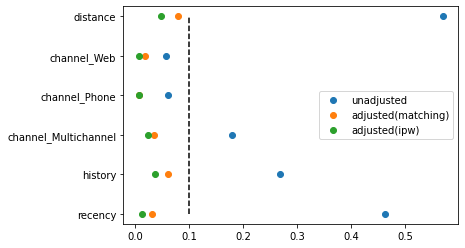

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(unadjusted_asam, unadjusted_asam.index, label='unadjusted')
plt.scatter(matching_adjusted_asam, matching_adjusted_asam.index, label='adjusted(matching)')
plt.scatter(ipw_adjusted_asam, ipw_adjusted_asam.index, label='adjusted(ipw)')
plt.vlines(0.1, 0, len(unadjusted_asam)-1, linestyles='dashed')
plt.legend()

# メール施策

## データの作成

In [111]:
from sklearn.model_selection import train_test_split

male_df_train, male_df_test = train_test_split(male_df, train_size=0.5, random_state=529)
male_df_train = male_df_train[male_df_train['treatment'] == 0]

In [144]:
predict_model = logit('conversion ~ recency + history_segment + channel + zip_code', data=male_df_train).fit()
pred_cv = predict_model.predict(male_df_test)
pred_cv_rank = pd.Series(pred_cv, name='proba').rank(pct=True)  # パーセントランク
mail_assign = np.random.binomial(n=1, p=pred_cv_rank)

         Current function value: 0.030664
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [145]:
male_df_test['mail_assign'] = mail_assign
male_df_test['ps'] = pred_cv_rank

ml_male_df = (
    male_df_test[
                 ((male_df_test['treatment'] == 1) & (male_df_test['mail_assign'] == 1)) |
                 ((male_df_test['treatment'] == 0) & (male_df_test['mail_assign'] == 0))
                 ]
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


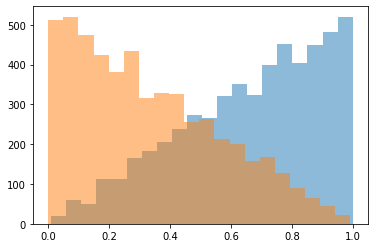

In [165]:
plt.hist(ml_male_df[ml_male_df['treatment']==1]['ps'], bins=20, alpha=0.5)
plt.hist(ml_male_df[ml_male_df['treatment']==0]['ps'], bins=20, alpha=0.5)
plt.show()

## RCTと平均の比較

In [146]:
from statsmodels.formula.api import ols

rct_male = ols('spend ~ treatment', data=male_df_test).fit()
rct_male.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6476,0.139,4.646,0.000,0.374,0.921
treatment,0.7798,0.197,3.949,0.000,0.393,1.167


In [147]:
ml_male_lm = ols('spend ~ treatment', data=ml_male_df).fit()
ml_male_lm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6011,0.219,2.744,0.006,0.172,1.031
treatment,1.1766,0.309,3.808,0.000,0.571,1.782


## 傾向スコアを使った分析

In [155]:
# 傾向スコアマッチング
d = get_matching_data(ml_male_df, 'treatment', ml_male_df['ps'])
ols('spend ~ treatment', data=d).fit().summary().tables[1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2674,0.196,1.367,0.172,-0.116,0.651
treatment,1.5103,0.277,5.457,0.000,0.968,2.053


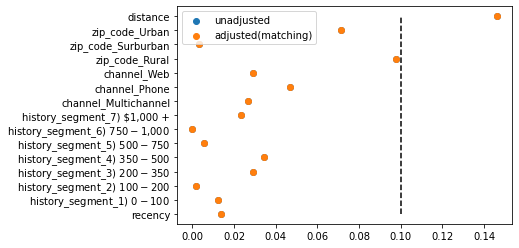

In [177]:
d = get_matching_data(d, 'treatment', ml_male_df['ps'])
unadjusted_asam = calculate_asam(d, 'treatment', ['recency', 'history_segment', 'channel', 'zip_code'])
matching_adjusted_asam = calculate_asam(d, 'treatment', ['recency', 'history_segment', 'channel', 'zip_code'])

plt.scatter(unadjusted_asam, unadjusted_asam.index, label='unadjusted')
plt.scatter(matching_adjusted_asam, matching_adjusted_asam.index, label='adjusted(matching)')
plt.vlines(0.1, 0, len(unadjusted_asam)-1, linestyles='dashed')
plt.legend()

In [178]:
ml_male_df2 = ml_male_df.astype({"treatment":'bool'}, copy=False)  # treatmentをbool化

model=CausalModel(
    data = ml_male_df2,
    treatment='treatment',
    outcome='spend',
    common_causes=['recency', 'history_segment', 'channel', 'zip_code'],
)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# 最近傍マッチング
nearest_ate = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching",
    target_units='ate',
)
nearest_att = model.estimate_effect(
    identified_estimand, 
    method_name="backdoor.propensity_score_matching",
    target_units='att', 
)

print(f'ATE: {nearest_ate.value}')  # ATEだが、定義のせいかずれが大きい
print(f'ATT: {nearest_att.value}')

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['treatment'] on outcome ['spend']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['history_segment', 'recency', 'zip_code', 'U', 'channel']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+history_segment+recency+zip_code+channel
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

ATE: 1.6406997384155448
ATT: 1.4837005387330482


In [167]:
# IPW
ipw_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units='ate',
)

print(f'ATE: {ipw_estimate.value}')  # RCTの結果に近い


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: spend~treatment+history_segment+recency+zip_code+channel
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ATE: 0.7279281644598576
